In [1]:
import tensorflow as tf
import requests
import numpy as np
import re
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import pandas as pd
from pandas_market_calendars import get_calendar, MarketCalendar
from geopy.geocoders import Nominatim
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


# Import data

In [105]:
path = "C:/CodeTest1/Venv1/SalesFeb2023/"
file1 = "Query1.xlsx"
file2 = "Query2.xlsx"
df1 = pd.read_excel(path + file1)
df2 = pd.read_excel(path + file2)

In [106]:
# define the search phrase
search_phrase = 'Aappakadai Indian Chettinad - Santa Clara, CA'

# create a regular expression pattern
pattern = re.compile(search_phrase, flags=re.IGNORECASE)

# create a boolean mask to filter the dataframe based on the pattern
mask = df1['CustomerName'].str.contains(pattern)

# apply the boolean mask to the dataframe to get the filtered rows
filtered_df = df1[mask]

# print the filtered dataframe
print(filtered_df)

       SalesDate                                   CustomerName  C_TotalSales
2     2023-02-09  Aappakadai Indian Chettinad - Santa Clara, CA       2573.13
416   2023-01-06  Aappakadai Indian Chettinad - Santa Clara, CA       6531.73
533   2022-10-29  Aappakadai Indian Chettinad - Santa Clara, CA       5540.77
673   2022-12-03  Aappakadai Indian Chettinad - Santa Clara, CA       7461.19
829   2022-10-16  Aappakadai Indian Chettinad - Santa Clara, CA       7939.08
...          ...                                            ...           ...
32056 2022-06-03  Aappakadai Indian Chettinad - Santa Clara, CA       8213.16
32083 2023-02-16  Aappakadai Indian Chettinad - Santa Clara, CA       2027.89
32133 2023-01-13  Aappakadai Indian Chettinad - Santa Clara, CA      10740.93
32186 2023-01-16  Aappakadai Indian Chettinad - Santa Clara, CA       3750.53
32272 2022-12-13  Aappakadai Indian Chettinad - Santa Clara, CA       2343.51

[274 rows x 3 columns]


<Axes: >

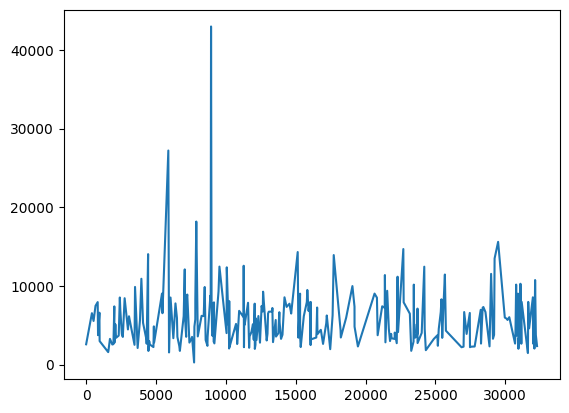

In [107]:
#Choose Customer
filtered_df['C_TotalSales'].plot()

# Dealing with outliers

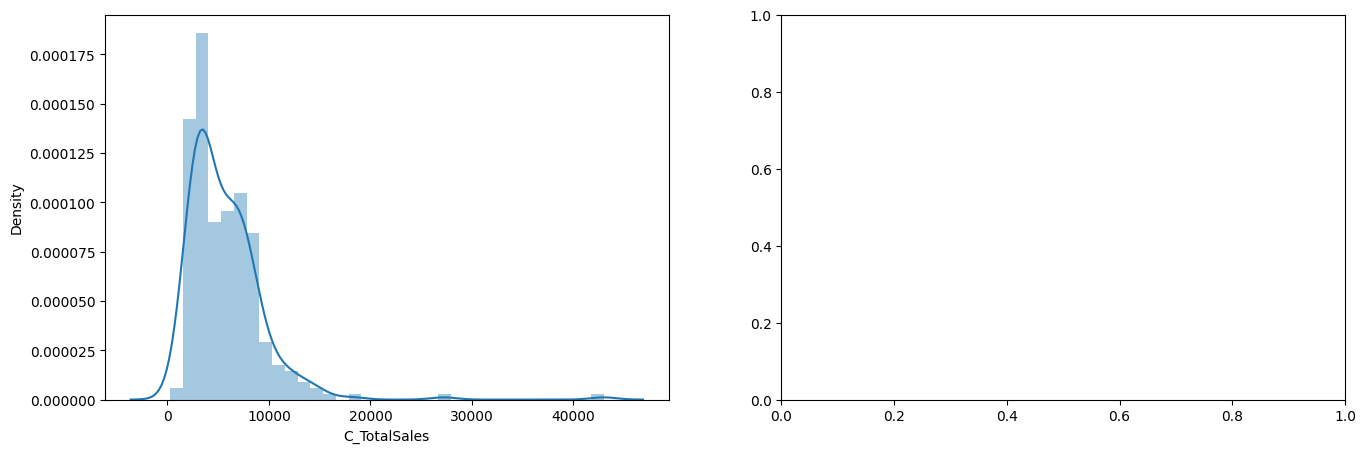

In [108]:
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(filtered_df['C_TotalSales'])
plt.subplot(1,2,2)
# sns.distplot(df['placement_exam_marks'])
plt.show()

In [109]:
print("Highest allowed",filtered_df['C_TotalSales'].mean() + 3*filtered_df['C_TotalSales'].std())
print("Lowest allowed",filtered_df['C_TotalSales'].mean() - 3*filtered_df['C_TotalSales'].std())

Highest allowed 17670.530455336237
Lowest allowed -6195.7868786939


In [112]:

#Shows all possible outliers
filtered_df[(filtered_df['C_TotalSales'] > 17670.530455336237) | (filtered_df['C_TotalSales'] < -6195.7868786939)]


,SalesDate,CustomerName,C_TotalSales
5884,2023-01-20,"Aappakadai Indian Chettinad - Santa Clara, CA",27211.25
7885,2022-12-21,"Aappakadai Indian Chettinad - Santa Clara, CA",18178.49
8941,2022-11-20,"Aappakadai Indian Chettinad - Santa Clara, CA",42985.83


In [ ]:
# upper_limit = filtered_df['C_TotalSales'].mean() + 3*filtered_df['C_TotalSales'].std()
# lower_limit = filtered_df['C_TotalSales'].mean() - 3*filtered_df['C_TotalSales'].std()

<Axes: >

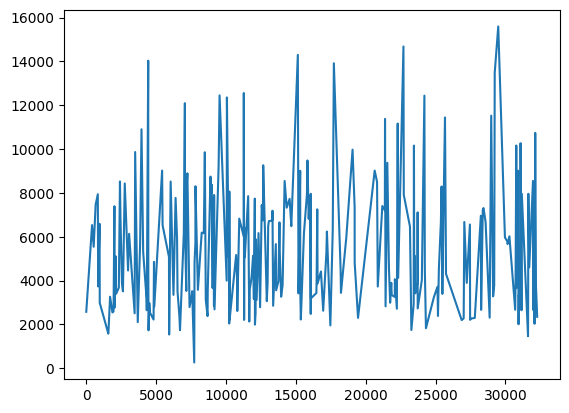

In [113]:
#Trim Outliers
new_df = filtered_df[(filtered_df['C_TotalSales'] < 17670.530455336237) & (filtered_df['C_TotalSales'] > -6195.7868786939)]
new_df.C_TotalSales.plot()

# Time Series Model

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime

import seaborn as sns

In [127]:
DF = new_df.copy()

In [128]:
DF.describe()

,C_TotalSales
count,271.000000
mean,5474.776015
std,2917.019853
min,259.560000
25%,3193.875000
50%,4814.340000
75%,7317.895000
max,15597.740000


In [129]:
DF = DF.rename(columns = {'SalesDate': 'ds', 'C_TotalSales': 'ts'})

In [130]:
DF.drop(labels='CustomerName',axis=1,inplace=True)

In [131]:
DF.columns

Index(['ds', 'ts'], dtype='object')

# Seasonal Decomposition

In [132]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [133]:
decomposition = seasonal_decompose(DF['ts'], period = 30, extrapolate_trend = 4)

In [156]:
Decom_Df = DF
Decom_Df.loc[:, "trend"] = decomposition.trend
Decom_Df.loc[:, "seasonal"] = decomposition.seasonal
Decom_Df.loc[:, "residual"] = decomposition.resid

In [157]:
def plot_decomposition(df, ts,trend,seasonal, residual):

  f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15, 5), sharex = True)

  ax1.plot(df[ts], label = 'Original', c = 'b')
  ax1.legend(loc = 'best')
  ax1.tick_params(axis = 'x', rotation = 45)

  ax2.plot(df[trend], label = 'Trend', c = 'lime')
  ax2.legend(loc = 'best')
  ax2.tick_params(axis = 'x', rotation = 45)

  ax3.plot(df[seasonal],label = 'Seasonality', c = 'm')
  ax3.legend(loc = 'best')
  ax3.tick_params(axis = 'x', rotation = 45)

  ax4.plot(df[residual], label = 'Residuals', c = 'r')
  ax4.legend(loc = 'best')
  ax4.tick_params(axis = 'x', rotation = 45)
  plt.tight_layout()

  #plt.subtitle('Signal Decomposition of  %s' %(ts), x =0.5, y= 1.05, fontsize = 18)
  plt.show()

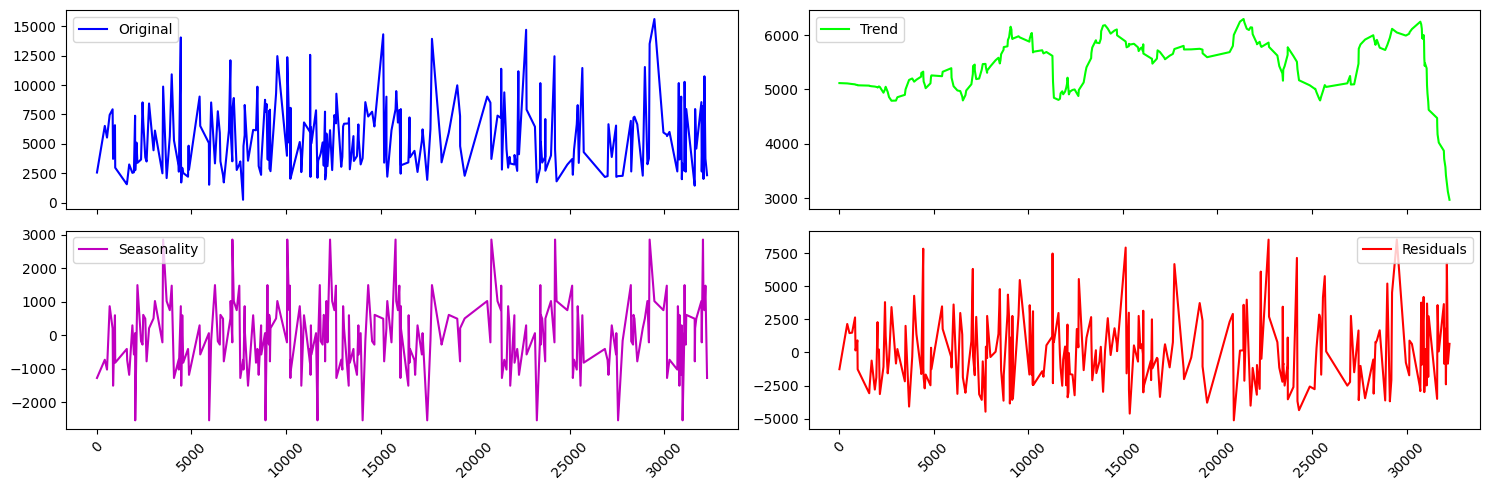

In [158]:
plot_decomposition(Decom_Df, ts = 'ts', trend = 'trend', seasonal = 'seasonal', residual = 'residual')

# Subtracting out the trend

<Axes: >

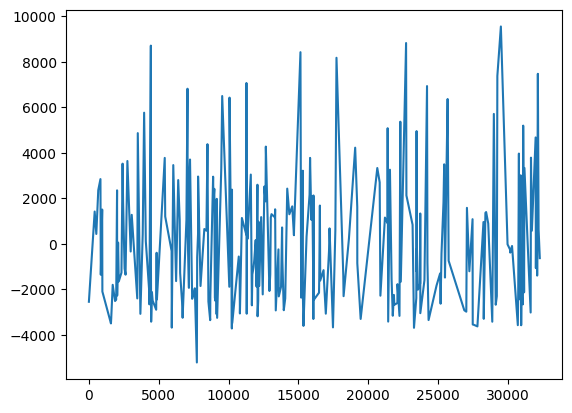

In [159]:
Decom_Df['No_Trend'] = Decom_Df.ts - Decom_Df.trend
Decom_Df.No_Trend.plot()
# Decom_Df.ts.plot()

# Apply different model on ts with trend subtracted

# An RNN

In [140]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
Decom_Df['No_Trend'] = scaler.fit_transform(Decom_Df[['No_Trend']])

# Create sequences of fixed length (e.g., 30 time steps)
sequence_length = 30

X, y = [], []
for i in range(len(Decom_Df) - sequence_length):
    X.append(Decom_Df['No_Trend'].iloc[i:i + sequence_length])
    y.append(Decom_Df['No_Trend'].iloc[i + sequence_length])

X = np.array(X)
y = np.array(y)
X.shape
# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(241, 30, 1)

In [141]:
#Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [142]:
X_test.shape

(49, 30, 1)

In [143]:
# Create LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [144]:
# Train Model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))


Epoch 1/50
6/6 [==============================] - 3s 119ms/step - loss: 0.1166 - val_loss: 0.0464
Epoch 2/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0495 - val_loss: 0.0461
Epoch 3/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0420 - val_loss: 0.0520
Epoch 4/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0429 - val_loss: 0.0467
Epoch 5/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0405 - val_loss: 0.0456
Epoch 6/50
6/6 [==============================] - 0s 21ms/step - loss: 0.0409 - val_loss: 0.0452
Epoch 7/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0396 - val_loss: 0.0455
Epoch 8/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0397 - val_loss: 0.0457
Epoch 9/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0396 - val_loss: 0.0451
Epoch 10/50
6/6 [==============================] - 0s 22ms/step - loss: 0.0397 - val_loss: 0.0450
Epoch 11/50
6/6 [===========

In [145]:
# make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Inverse transform the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))


2/2 [==============================] - 1s 5ms/step


In [146]:
# Evaluate Model
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
# Run1
# Train RMSE: 4293.247928557457
# Test RMSE: 3227.6941782344925
# Run2 (no outliers)
# Train RMSE: 0.06967528361479482
# Test RMSE: 0.07035120350430553

Train RMSE: 2909.3748373671924
Test RMSE: 3138.366612423028


In [147]:
y_test_pred
y_test_actual

array([[  752.214     ],
       [-2118.04916667],
       [-3574.35516667],
       [  -20.44133333],
       [ 4642.2764    ],
       [-3043.82483333],
       [-3292.41      ],
       [ 3012.61466667],
       [ -390.1235    ],
       [-2282.72316667],
       [ 2418.2825    ],
       [ 9550.492     ],
       [-2655.5945    ],
       [ -248.0785    ],
       [-3180.0275    ],
       [ 3332.6045    ],
       [ 6364.157     ],
       [ 3461.39516667],
       [ 1137.38833333],
       [ 1683.89283333],
       [  439.24116667],
       [-1276.89716667],
       [  380.4995    ],
       [-1950.9095    ],
       [ 3495.67233333],
       [-2010.916     ],
       [-2440.73683333],
       [ 3045.087     ],
       [ 1160.28933333],
       [-2242.551     ],
       [-2360.9475    ],
       [-2433.482     ],
       [-1932.023     ],
       [-3717.35216667],
       [ 1064.84716667],
       [-1493.93316667],
       [ 1519.6205    ],
       [-3558.39966667],
       [-1405.93666667],
       [ 7470.83483333],


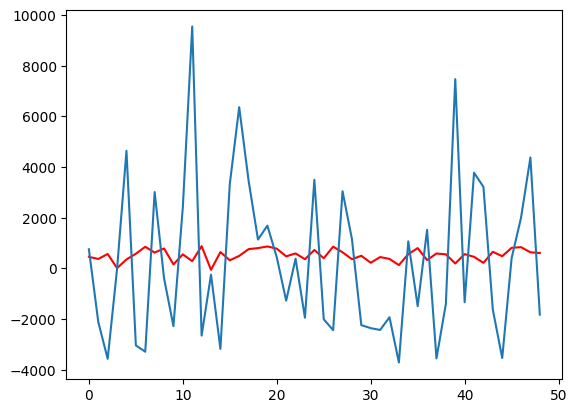

In [148]:
plt.plot(y_test_pred,c='red')
plt.plot(y_test_actual)
plt.show()

In [149]:
# R2
from sklearn.metrics import r2_score
r2_score(y_test_actual, y_test_pred)

-0.027510610767238042

In [151]:
# Decom_Df['No_Trend'] = Decom_Df.ts - Decom_Df.trend
plt.plot(y_test_pred +Decom_Df.trend)

ValueError: Length of values (49) does not match length of index (271)